In [1]:
%pip install numpy pillow pandas tensorflow keras matplotlib torch torchvision transformers gensim
import json
import pandas as pd 
import torch
from transformers import BertTokenizer, BertModel,pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import time
import PIL
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import pickle
import os
import random
import torch
import torch.nn as nn
from torchvision import transforms
import ast


Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_text(text_file_path):
    """
    Load text from a file and return it as a string.
    """
    with open(text_file_path, 'r', encoding='utf-8') as file:
        text = file.read().strip().split('\n')
    return text

def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids
      
def load_embeddings(embeddings_file_path):
    """
    Load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings
 
def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames
 


def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict


def get_img(img_path, bbox, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img
def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir,text_dir, embeddings_file_path, image_size):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)
    X, y, embeddings,texts = [], [], [],[]

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]
        

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            text_file= load_text('{}/text_c10/{}.txt'.format(text_dir, filename))
            img = get_img(img_name, bounding_box, image_size)
            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]
            text=text_file[embedding_ix]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
            texts.append(text)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)
    
    return X, y, embeddings,text
    

In [3]:
train_image, train_label, train_embedding,train_text=load_dataset(r"C:\Users\desai\Downloads\birds\train\filenames.pickle",r"C:\Users\desai\Downloads\birds\train\class_info.pickle",r"C:\Users\desai\Downloads\CUB_200_2011",r"C:\Users\desai\Downloads\cvpr2016_cub",r"C:\Users\desai\Downloads\birds\train\char-CNN-RNN-embeddings.pickle",(64,64))

C:\Users\desai\AppData\Local\Temp\ipykernel_21852\4146117692.py:46: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bounding_boxes = pd.read_csv(bounding_boxes_path,
C:\Users\desai\AppData\Local\Temp\ipykernel_21852\4146117692.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)


embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)


In [4]:
test_image, test_label, test_embedding,test_text=load_dataset(r"C:\Users\desai\Downloads\birds\test\filenames.pickle",r"C:\Users\desai\Downloads\birds\test\class_info.pickle",r"C:\Users\desai\Downloads\CUB_200_2011",r"C:\Users\desai\Downloads\cvpr2016_cub",r"C:\Users\desai\Downloads\birds\test\char-CNN-RNN-embeddings.pickle",(64,64))


C:\Users\desai\AppData\Local\Temp\ipykernel_21852\4146117692.py:46: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bounding_boxes = pd.read_csv(bounding_boxes_path,
C:\Users\desai\AppData\Local\Temp\ipykernel_21852\4146117692.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)


embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)


In [5]:
train_df=pd.DataFrame({
    "image":list(train_image),
    "train_text":train_text,
    "vector_emb":list(train_embedding)
})
train_df.head()

,image,train_text,vector_emb
0,"[[[104, 131, 143], [121, 142, 154], [135, 151,...","this��bird��has��a��yellow��breast,��taupe��be...","[0.069175765, 0.10133824, 0.021810336, 0.06439..."
1,"[[[53, 63, 69], [74, 83, 86], [79, 87, 89], [7...","this��bird��has��a��yellow��breast,��taupe��be...","[0.0054620877, 0.087856464, 0.028188782, 0.088..."
2,"[[[83, 103, 23], [80, 102, 26], [87, 111, 19],...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.09076574, -0.040317148, 0.13491416, 0.1705..."
3,"[[[150, 148, 153], [153, 151, 156], [155, 153,...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.008370306, 0.07140453, -0.049068503, -0.01..."
4,"[[[78, 69, 67], [83, 72, 71], [75, 63, 62], [5...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.31082967, 0.030447226, 0.094357274, -0.067..."


In [6]:
test_df=pd.DataFrame({
    "image":list(test_image),
    "train_text":test_text,
    "vector_emb":list(test_embedding)
})
test_df.head()

,image,train_text,vector_emb
0,"[[[104, 131, 143], [121, 142, 154], [135, 151,...",this yellow breasted bird has a black cheek pa...,"[-0.10245901, 0.08354798, -0.055076048, -0.040..."
1,"[[[53, 63, 69], [74, 83, 86], [79, 87, 89], [7...",this yellow breasted bird has a black cheek pa...,"[-0.056735758, 0.09200595, 0.035896774, 0.1446..."
2,"[[[83, 103, 23], [80, 102, 26], [87, 111, 19],...",this yellow breasted bird has a black cheek pa...,"[0.1231875, 0.13404414, 0.056584906, 0.0648051..."
3,"[[[150, 148, 153], [153, 151, 156], [155, 153,...",this yellow breasted bird has a black cheek pa...,"[-0.22357073, 0.09971619, 0.04753186, 0.004042..."
4,"[[[78, 69, 67], [83, 72, 71], [75, 63, 62], [5...",this yellow breasted bird has a black cheek pa...,"[-0.02236132, -0.025680661, 0.47425216, 0.1033..."


In [7]:
# conditioning

In [8]:
class CA_NET(nn.Module):
    def __init__(self, embedding_text_dim=1024, c_dim=128, device='cuda'):
        super(CA_NET, self).__init__()
        self.embedding_text_dim = embedding_text_dim
        self.c_dim = c_dim
        self.device = device  # Save device as a class attribute
        self.fc = nn.Linear(embedding_text_dim, c_dim * 2, bias=True).to(self.device)
        self.relu = nn.ReLU().to(self.device)
            
    def encode(self, text_embedding):
        text_embedding = text_embedding.to(self.device)
        x = self.relu(self.fc(text_embedding))  # reducing the text embedding dimension to 256 then using LRLU
        mean = x[:, :self.c_dim]  # take the first 128 to be the mean
        log_variance = x[:, self.c_dim:]  # take the last 128 to be the log variance
        return mean, log_variance

    def reparametrize(self, mean, log_variance):
        std = log_variance.mul(0.5).exp_()  # calculating the std from the log_variance through taking the exp then the sqrt
        eps = torch.randn_like(std)      
        return eps.mul(std).add_(mean)  # create c: eps*std + mean
        
        
    def forward(self, text_embedding):
        mean, log_variance = self.encode(text_embedding)
        c = self.reparametrize(mean, log_variance)
        return c, mean, log_variance  # c (128,128)


In [9]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(True))
    return block


In [10]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf, nef,device='cuda',bcondition=True):
        super(D_GET_LOGITS, self).__init__()
        self.df_dim = ndf #64
        self.ef_dim = nef #128
        self.bcondition = bcondition
        self.device = device
        if bcondition:
            self.outlogits = nn.Sequential(
                conv3x3(ndf * 8 + nef, ndf * 8), # 640 , 512
                nn.BatchNorm2d(ndf * 8), 
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid()).to(self.device)
        else:
            self.outlogits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid()).to(self.device)

    def forward(self, h_code, c_code=None):
        # conditioning output
        if self.bcondition and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((h_code, c_code), 1)

        else:
            h_c_code = h_code
        output = self.outlogits(h_c_code)

        return output.view(-1)
    


In [11]:
class STAGE1_G(nn.Module):
    def __init__(self, device='cuda'):
        super(STAGE1_G, self).__init__()
        self.device = device
        self.gf_dim = 128 * 8  # 128 * 8 = 1024
        self.ef_dim = 128  # 128
        self.z_dim = 100  # 100
        self.define_module()

    def define_module(self):
        ninput = self.z_dim + self.ef_dim  # 100 + 128 = 228
        ngf = self.gf_dim  # 1024
        self.ca_net = CA_NET(device=self.device).to(self.device)

        # -> ngf x 4 x 4 == 1024 x 4 x 4
        self.fc = nn.Sequential(
            nn.Linear(ninput, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.ReLU(True)).to(self.device)

        # ngf x 4 x 4 -> ngf/2 x 8 x 8
        self.upsample1 = upBlock(ngf, ngf // 2).to(self.device)
        # -> ngf/4 x 16 x 16
        self.upsample2 = upBlock(ngf // 2, ngf // 4).to(self.device)
        # -> ngf/8 x 32 x 32
        self.upsample3 = upBlock(ngf // 4, ngf // 8).to(self.device)
        # -> ngf/16 x 64 x 64
        self.upsample4 = upBlock(ngf // 8, ngf // 16).to(self.device)
        # -> 3 x 64 x 64
        self.img = nn.Sequential(
            conv3x3(ngf // 16, 3),
            nn.Tanh()).to(self.device)

    def forward(self, text_embedding, noise):
        
        c_code, mu, logvar = self.ca_net(text_embedding)
        z_c_code = torch.cat((noise, c_code), 1).to(self.device)
        h_code = self.fc(z_c_code)

        h_code = h_code.view(-1, self.gf_dim, 4, 4)
        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)
        # state size 3 x 64 x 64
        fake_img = self.img(h_code)
        return fake_img, mu, logvar


In [12]:
class STAGE1_D(nn.Module):
    def __init__(self, device='cuda'):
        super(STAGE1_D, self).__init__()
        self.device = device
        self.df_dim = 64  # 64
        self.ef_dim = 128  # 128
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim  # 64, 128
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # state size (ndf * 8) x 4 x 4)
            nn.LeakyReLU(0.2, inplace=True)
        ).to(self.device)

        self.get_cond_logits = D_GET_LOGITS(ndf, nef, device=self.device).to(self.device)  # 64, 128
        self.get_uncond_logits = None

    def forward(self, image):
        img_embedding = self.encode_img(image)
        return img_embedding


In [13]:
def KL_loss(mu, logvar):
    # Calculate the KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(KLD)


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from torchvision import transforms

class MyDataset(Dataset):
    def __init__(self, dataframe, imsize=64, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.imsize = imsize
        self.data = dataframe

    def get_img(self, image_data):
        """
        Load and transform the image.
        """
        if isinstance(image_data, str):
            img = Image.open(image_data).convert('RGB')
        elif isinstance(image_data, np.ndarray):
            img = Image.fromarray(image_data)
        else:
            raise TypeError("Unsupported image data type.")
        
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __getitem__(self, index):
        row = self.data.iloc[index]
        # Convert the string representation of the vector to a list of floats
        vector = row['vector_emb']
        # Convert to a numpy array
#         vector = np.array([float(x) for x in vector_str.strip('[]').split() if x])
        embedding = torch.tensor(vector, dtype=torch.float32)
        img = self.get_img(row['image'])
        if self.target_transform is not None:
            embedding = self.target_transform(embedding)
        comment = row['train_text']
        return img, embedding, comment

    def __len__(self):
        return len(self.data)

In [15]:
train_df.head()

,image,train_text,vector_emb
0,"[[[104, 131, 143], [121, 142, 154], [135, 151,...","this��bird��has��a��yellow��breast,��taupe��be...","[0.069175765, 0.10133824, 0.021810336, 0.06439..."
1,"[[[53, 63, 69], [74, 83, 86], [79, 87, 89], [7...","this��bird��has��a��yellow��breast,��taupe��be...","[0.0054620877, 0.087856464, 0.028188782, 0.088..."
2,"[[[83, 103, 23], [80, 102, 26], [87, 111, 19],...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.09076574, -0.040317148, 0.13491416, 0.1705..."
3,"[[[150, 148, 153], [153, 151, 156], [155, 153,...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.008370306, 0.07140453, -0.049068503, -0.01..."
4,"[[[78, 69, 67], [83, 72, 71], [75, 63, 62], [5...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.31082967, 0.030447226, 0.094357274, -0.067..."


In [16]:
# Define the image transformations
transform = transforms.Compose([
    transforms.RandomCrop(64),  # Randomly crop the image to the specified size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (data augmentation)
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


# Create Dataset objects
train_dataset =MyDataset(dataframe=train_df, transform=transform)

test_dataset = MyDataset(dataframe=test_df ,transform=transform)


# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

In [18]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define the device
num_epochs = 5
lr_decay_step = 600
generator_lr = 2e-4
discriminator_lr = 2e-4

# Instantiate the networks
Gen1 = STAGE1_G(device=device)
Gen1.apply(weights_init)
Dis1 = STAGE1_D(device=device)
Dis1.apply(weights_init)

# Define optimizers
opt_d1 = torch.optim.Adam(Dis1.parameters(), lr=generator_lr, betas=(0.5, 0.999))
opt_g1 = torch.optim.Adam(Gen1.parameters(), lr=discriminator_lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()



In [19]:
import torchvision

# Function to denormalize and plot images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Assuming the images were normalized to [-1, 1]
    return tensor.clamp(0, 1)

def plot_images(images, nrow=4, title='Images'):
    images = denormalize(images)
    grid_img = torchvision.utils.make_grid(images.cpu(), nrow=nrow, padding=2)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()


Epoch [1/5], Discriminator Loss: 1.2369228790132263, Generator Loss: 1.254567042314749
Epoch [1/5], Discriminator Loss: 1.2369228790132263, Generator Loss: 1.254567042314749


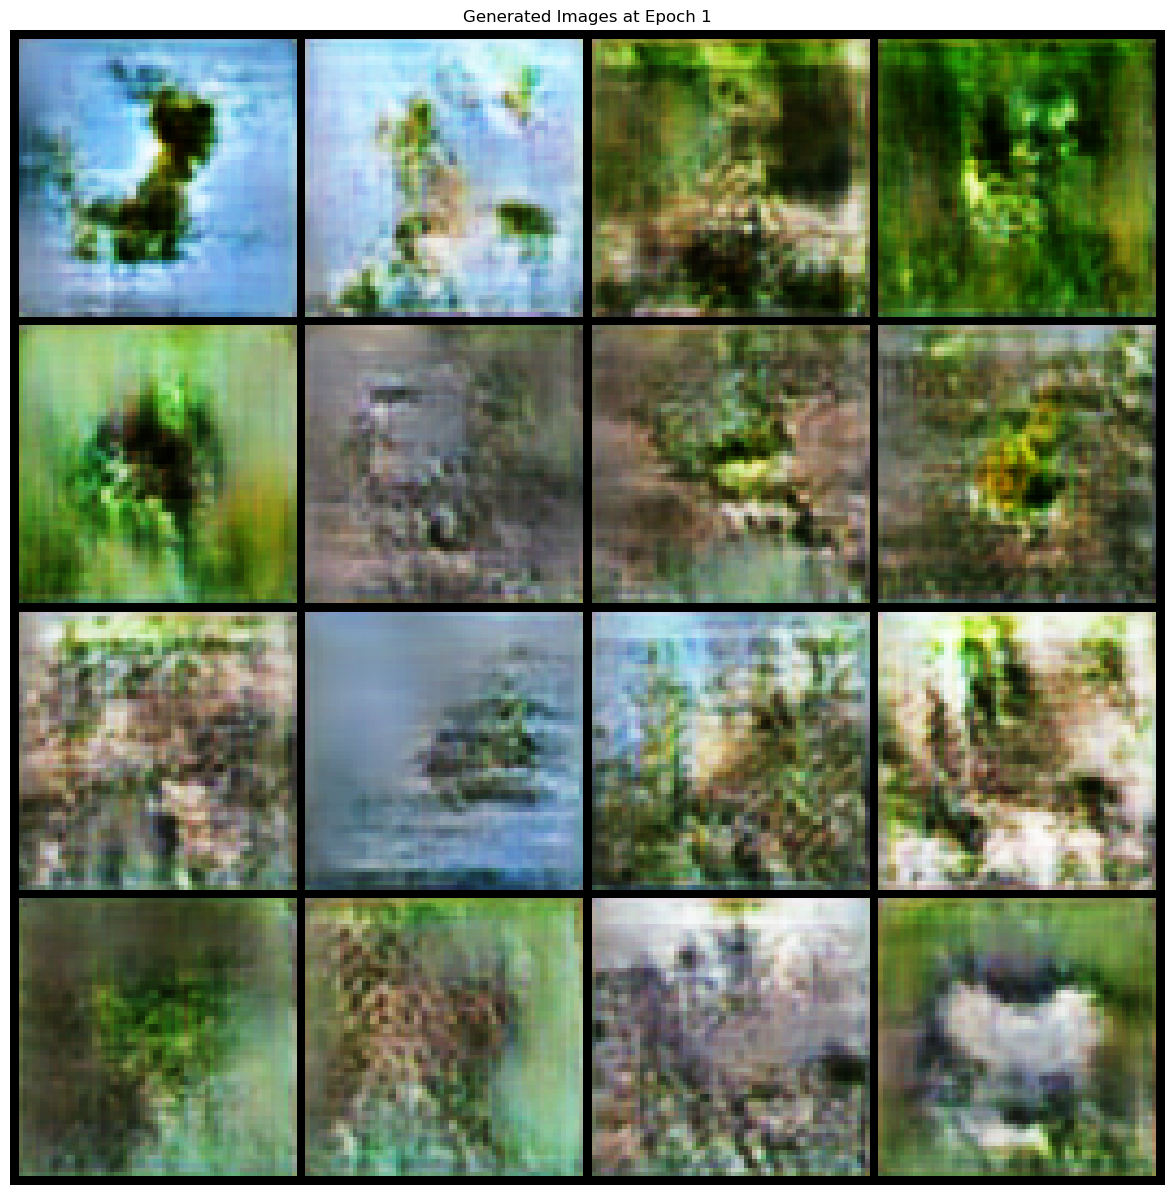

Epoch [2/5], Discriminator Loss: 1.2060057430816211, Generator Loss: 1.2217045413504402
Epoch [2/5], Discriminator Loss: 1.2060057430816211, Generator Loss: 1.2217045413504402


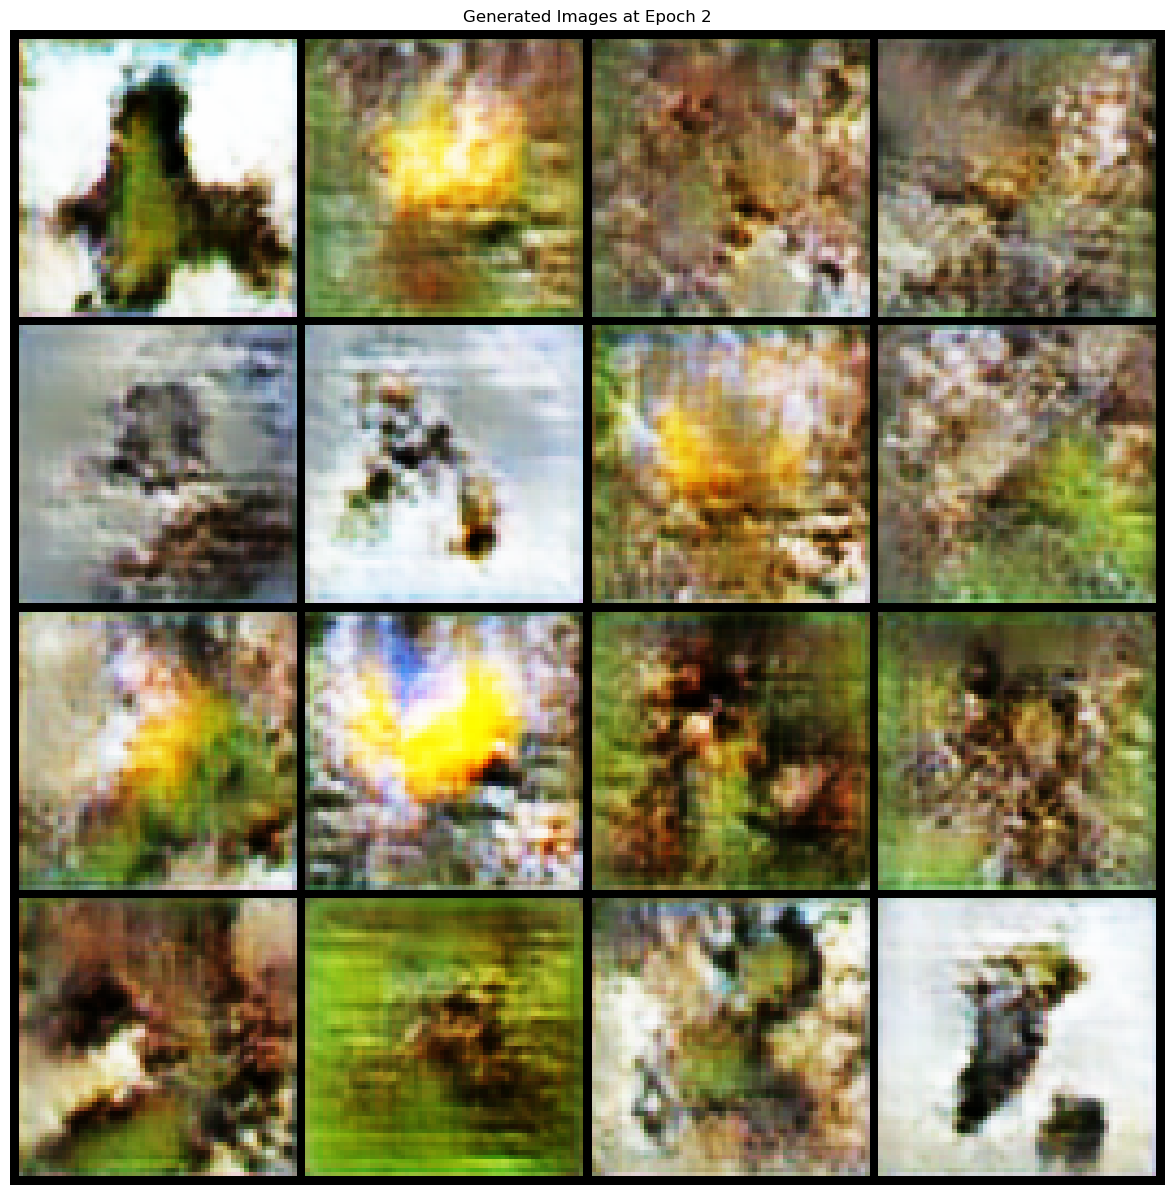

Epoch [3/5], Discriminator Loss: 1.1731702942642377, Generator Loss: 1.266840871182277
Epoch [3/5], Discriminator Loss: 1.1731702942642377, Generator Loss: 1.266840871182277


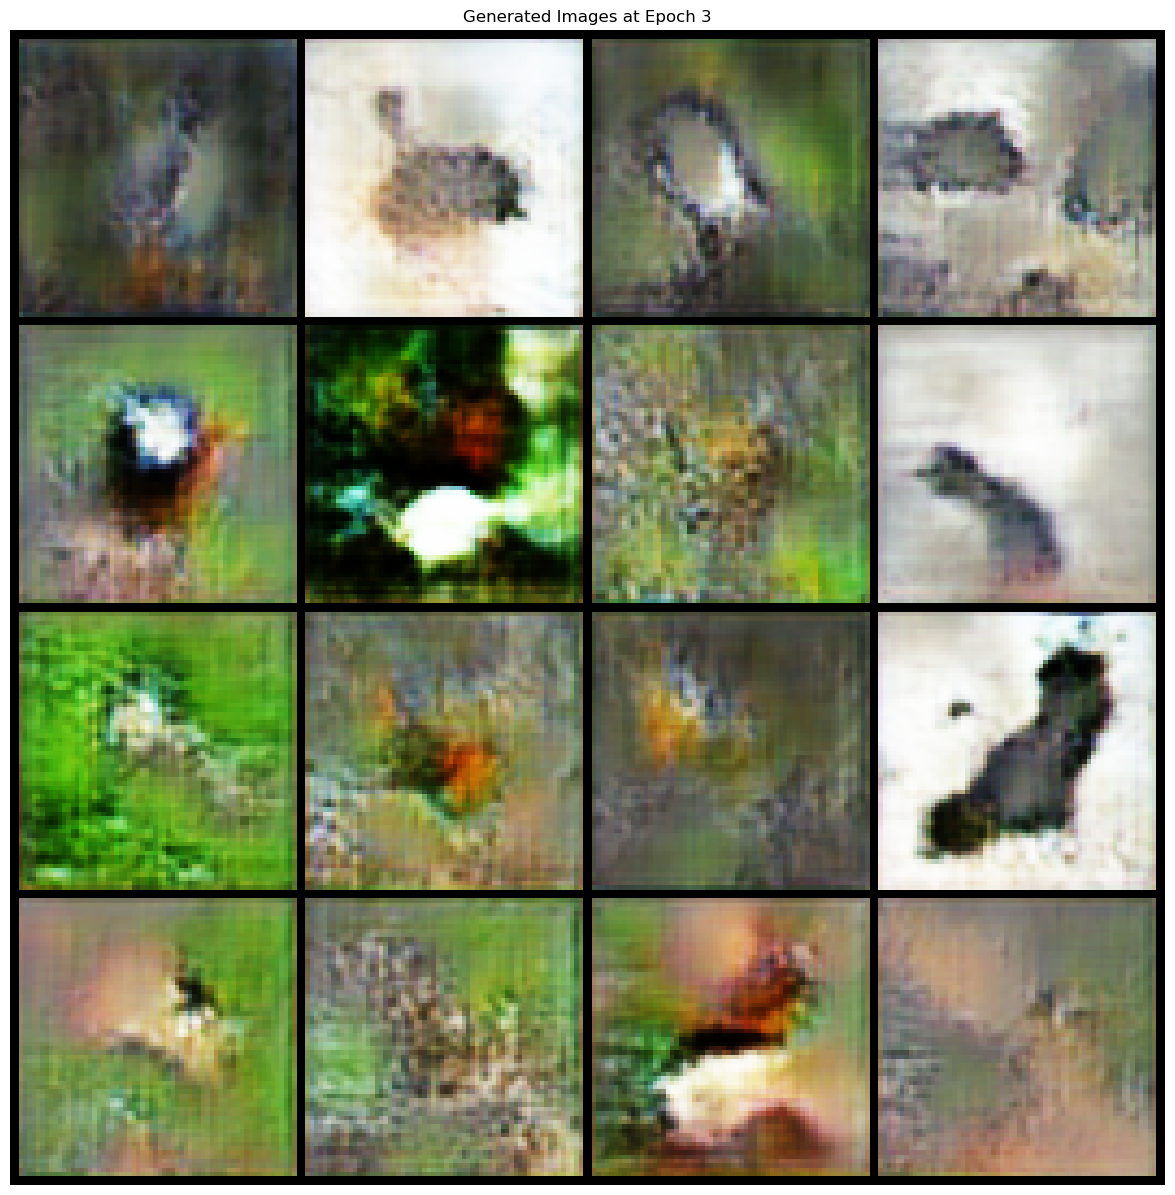

Epoch [4/5], Discriminator Loss: 1.1496730579746712, Generator Loss: 1.210359458228667
Epoch [4/5], Discriminator Loss: 1.1496730579746712, Generator Loss: 1.210359458228667


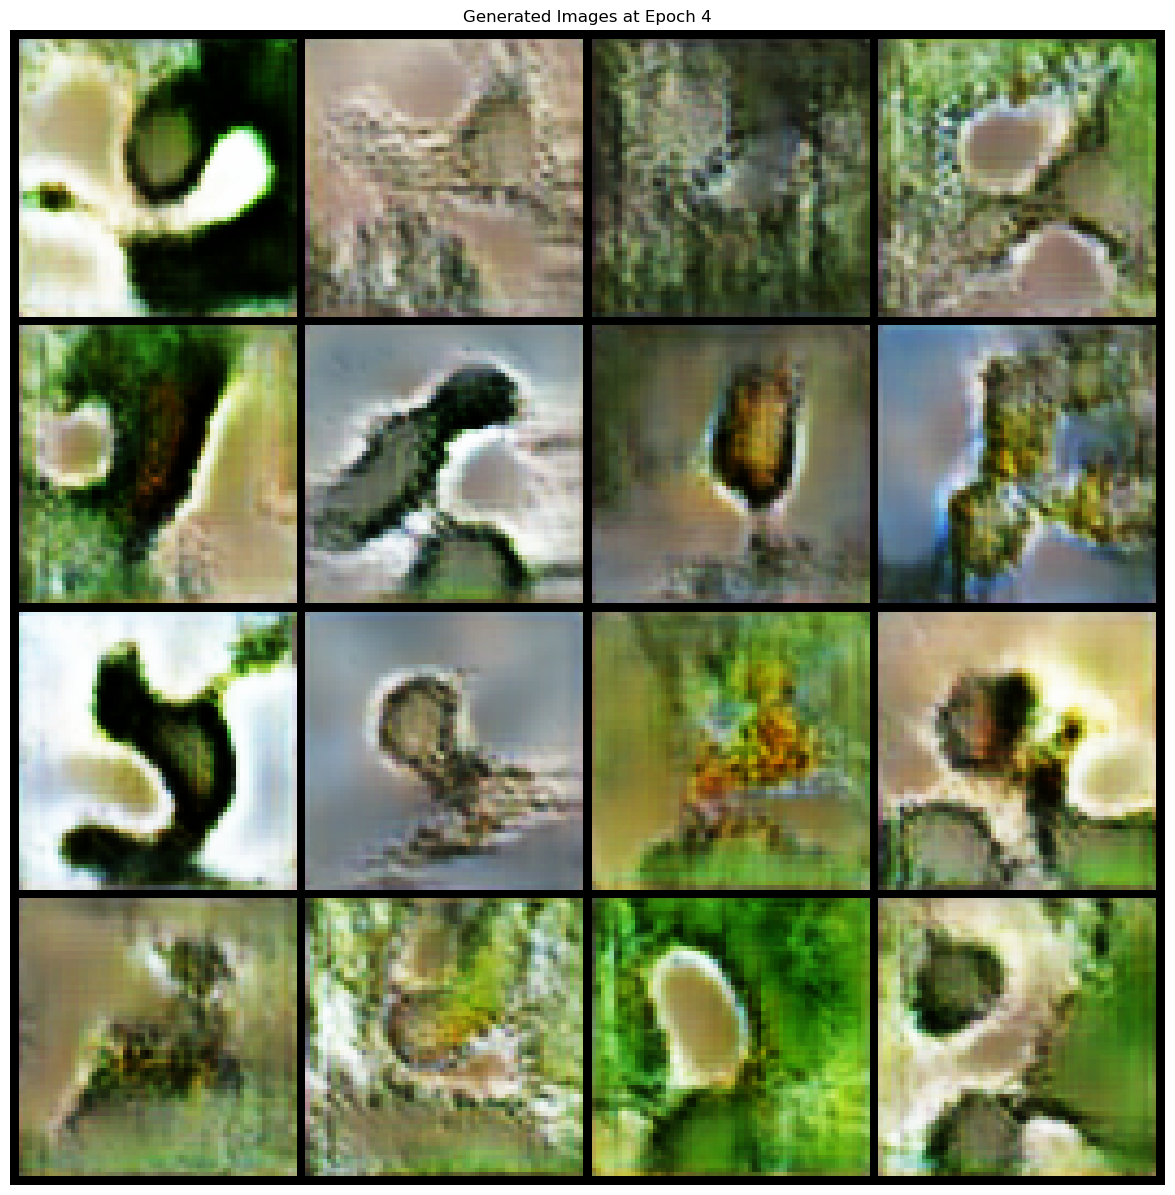

Epoch [5/5], Discriminator Loss: 1.1293970560856004, Generator Loss: 1.1720103672940096
Epoch [5/5], Discriminator Loss: 1.1293970560856004, Generator Loss: 1.1720103672940096


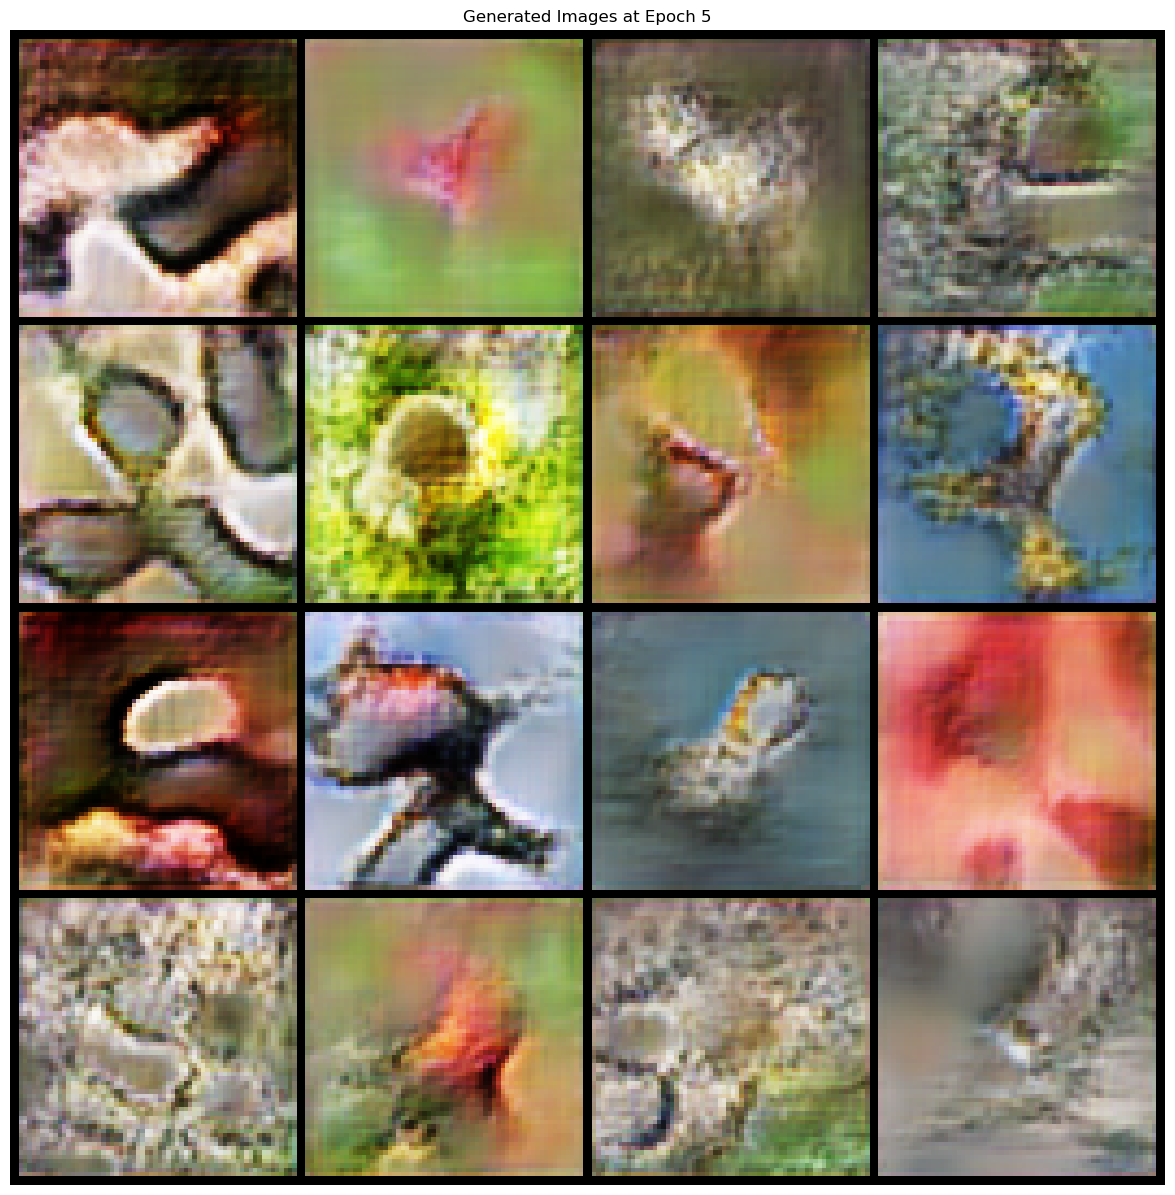

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np



# Initialize learning rate schedulers
scheduler_g1 = StepLR(opt_g1, step_size=lr_decay_step, gamma=0.5)
scheduler_d1 = StepLR(opt_d1, step_size=lr_decay_step, gamma=0.5)

for epoch in range(num_epochs):
    Gen1.train()
    Dis1.train()
    D_loss = []
    G_loss = []
    
    for real_img, real_embed ,comment in train_loader:
        # Move data to device
        real_img = real_img.to(device)
        real_embed = real_embed.to(device)

        # Generate noise
        noise_d = torch.randn(real_img.size(0), 100).to(device)
        
        # Train Discriminator
        fake_img_disc, mean_d, var_d = Gen1(real_embed, noise_d)
        fake_img_disc = fake_img_disc.detach()
        mean_d = mean_d.detach()
        var_d = var_d.detach()
        
        opt_d1.zero_grad()
        
        real_d1_feature = Dis1(real_img)
        fake_d1_feature = Dis1(fake_img_disc)
        
        d1_real_op = Dis1.get_cond_logits(real_d1_feature, mean_d)
        d1_fake_op = Dis1.get_cond_logits(fake_d1_feature, mean_d)
        
        wrong_mean_d = torch.roll(mean_d, 1, 0)
        d1_mislabel_op = Dis1.get_cond_logits(real_d1_feature, wrong_mean_d)
        
        # Adjusting the real labels to be exactly 1
        real_labels = torch.ones(d1_real_op.shape[0]).to(device)
        fake_labels = torch.zeros(d1_fake_op.shape[0]).to(device)
        
        dloss_real = criterion(d1_real_op.squeeze(), real_labels)
        dloss_fake = criterion(d1_fake_op.squeeze(), fake_labels)
        dloss_mislabel = criterion(d1_mislabel_op.squeeze(), fake_labels)
        dloss_total =dloss_real + 0.5 * (dloss_fake + dloss_mislabel)
         
        D_loss.append(dloss_total.item())
        
        dloss_total.backward()
        opt_d1.step()
        
        # Train Generator
        opt_g1.zero_grad()
        
        noise_g = torch.randn(real_img.size(0), 100).to(device)
        fake_img_gen, mean_g, var_g = Gen1(real_embed, noise_g)
        mean_gd = mean_g.detach()
        
        fake_img_g = Dis1(fake_img_gen)
        g1_fake_op = Dis1.get_cond_logits(fake_img_g, mean_gd)
        
        real_labels = torch.ones(g1_fake_op.size()).to(device)
        
        gloss = criterion(g1_fake_op.squeeze(), real_labels)
        kl_loss = KL_loss(mean_gd, var_d)
        g_loss = gloss + kl_loss *  2.0
        G_loss.append(gloss.item())
    
        gloss.backward()
        opt_g1.step()

    scheduler_g1.step()
    scheduler_d1.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {np.mean(D_loss)}, Generator Loss: {np.mean(G_loss)}')
    #ploting real and generated images for each epoch 
    Gen1.eval()
    if epoch%1==0:
        with torch.no_grad():
            noise = torch.randn(16, 100).to(device)  # Generate noise for 16 images
            sample_embed = real_embed[:16]  # Use the first 16 embeddings

            # Generate images
            generated_images, _, _ = Gen1(sample_embed, noise)
            print(f'Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {np.mean(D_loss)}, Generator Loss: {np.mean(G_loss)}', flush=True)

            # Plot real and generated images
            plot_images(generated_images, title=f'Generated Images at Epoch {epoch+1}')

In [49]:
torch.save(Gen1.state_dict(), 'stage1_gen.pth')
torch.save(Dis1.state_dict(), 'stage1_dis.pth')

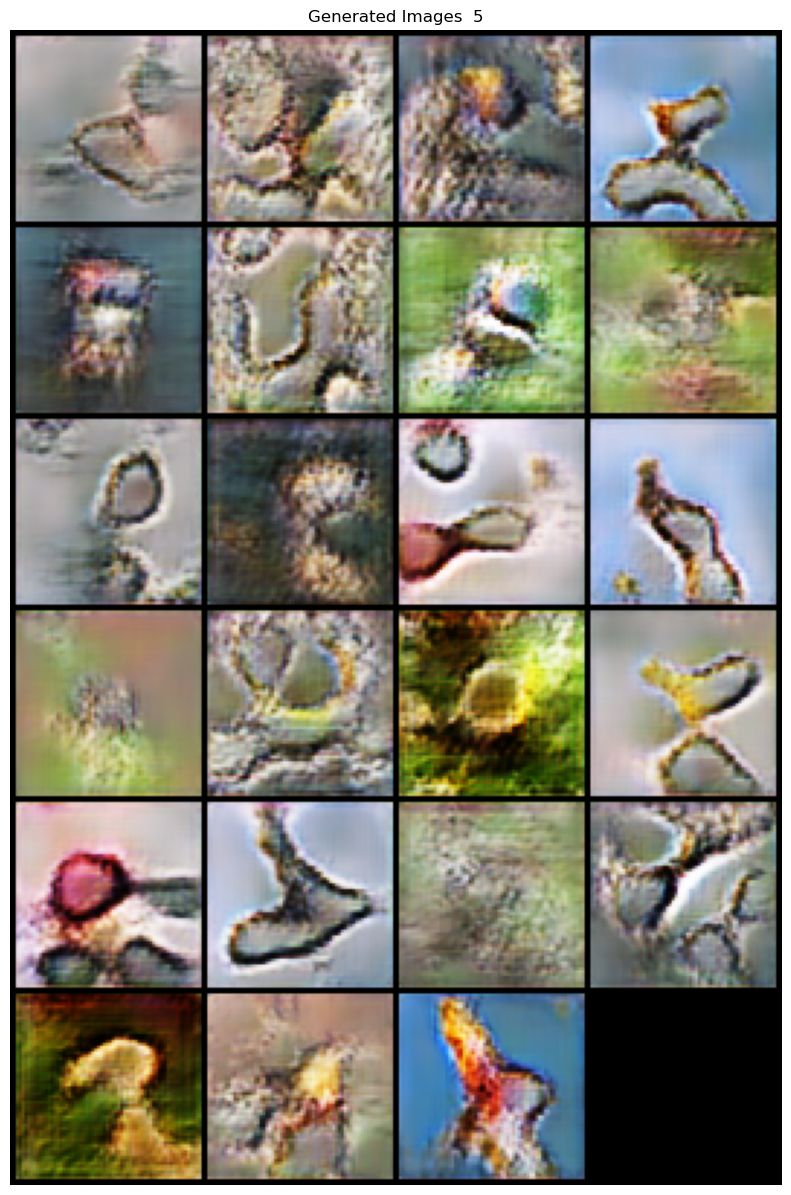

In [51]:
generated_images_list = []

with torch.no_grad():
    for real_img,real_emb,comment in train_loader:
        # Generate a batch of noise
        noise_batch = torch.randn(real_img.size(0), 100).to(device)
        
        
        # Get the corresponding batch of embeddings
        sample_embed_batch = real_emb.to(device)
        
        # Generate images for the current batch
        generated_images_batch, _, _ = Gen1(sample_embed_batch, noise_batch)
        
        # Convert generated images to numpy arrays and add to the list
        for_ploting=generated_images_batch.cpu()
        generated_images_np_batch = denormalize(generated_images_batch.cpu())
        generated_images_list.extend(generated_images_np_batch.numpy())
        
plot_images(for_ploting, title=f'Generated Images  {epoch+1}')

In [53]:
train_df['generated_images'] = generated_images_list
train_df.head()

,image,train_text,vector_emb,generated_images
0,"[[[104, 131, 143], [121, 142, 154], [135, 151,...","this��bird��has��a��yellow��breast,��taupe��be...","[0.069175765, 0.10133824, 0.021810336, 0.06439...","[[[0.32738858, 0.38962093, 0.41288513, 0.44156..."
1,"[[[53, 63, 69], [74, 83, 86], [79, 87, 89], [7...","this��bird��has��a��yellow��breast,��taupe��be...","[0.0054620877, 0.087856464, 0.028188782, 0.088...","[[[0.3002463, 0.32425186, 0.30902827, 0.319359..."
2,"[[[83, 103, 23], [80, 102, 26], [87, 111, 19],...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.09076574, -0.040317148, 0.13491416, 0.1705...","[[[0.32504195, 0.47414044, 0.6677419, 0.548594..."
3,"[[[150, 148, 153], [153, 151, 156], [155, 153,...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.008370306, 0.07140453, -0.049068503, -0.01...","[[[0.5810431, 0.7066826, 0.8099532, 0.85453814..."
4,"[[[78, 69, 67], [83, 72, 71], [75, 63, 62], [5...","this��bird��has��a��yellow��breast,��taupe��be...","[-0.31082967, 0.030447226, 0.094357274, -0.067...","[[[0.6625299, 0.7190321, 0.6976424, 0.71487725..."
